# Introduzione <a id="intro"></a>

Il presente progetto è stato sviluppato nell'ambito del corso di Fondamenti di Analisi dei Dati. L'obiettivo principale del progetto è applicare le tecniche e i metodi appresi durante il corso per analizzare un dataset reale, estrapolare informazioni significative, generare intuizioni utili relative alla classificazione. L'analisi si concentrerà su vari aspetti dei dati, tra cui la pulizia e la preparazione dei dati, l'analisi esplorativa...

Il dataset assegnato per questa analisi è l'Internet Advertisement dataset, un insieme di dati che rappresenta un insieme di possibili annunci pubblicitari su pagine Internet. Il compito principale associato a questo dataset è prevedere se un'immagine è un annuncio pubblicitario ("ad") o meno ("nonad").

## Indice:
* [Descrizione del Dataset](#descr-dataset)
* [Caricamento dei dati](#caricamento-dati)
    * [Acquisizione del Dataset](#acquisizione-dataset)
* [Pre-processing dei dati](#pre-processing)
    * [Gestione valori mancanti](#valori-mancanti)


# Descrizione del Dataset <a id="descr-dataset"></a>

Internet Advertisement Dataset è stato generato tra aprile e luglio 1998. È composto da 3279 istanze, di cui 2821 sono classificate come "nonad" e 458 come "ad". Ogni istanza è descritta da 1558 attributi, di cui 3 continui e il resto binari. Gli attributi continui possono essere mancanti nel 28% delle istanze secondo quanto segnalato nella documentazione. Di seguito si propone uno schema della sua struttura:
* Nome del Dataset: Internet Advertisement Dataset
* Origine: Creato da Nicholas Kushmerick tra aprile e luglio 1998.
* Numero di Istanze: 3279 istanze, suddivise in 2821 "nonad" e 458 "ad".
* Numero di Attributi: 1558 attributi, di cui 3 continui e il resto binari.
* Valori Mancanti: Il 28% delle istanze manca di uno o più attributi continui.
* Descrizione degli Attributi: Gli attributi continui codificano la geometria dell'immagine (se disponibile); Gli attributi binari sono relativi alla presenza o meno di frasi che si verificano nell'URL dell'immagine, nell'URL e nel testo alternativo dell'immagine, nel testo dell'ancora e nelle parole che si verificano vicino al testo dell'ancora.

Si noti inoltre che non è presente una suddivisione in train e test set prestabilita dagli autori del dataset. Il dataset viene distribuito secondo la seguente struttura:
* ad.names, qui sono presenti tutti i nomi dei 1558 attributi presenti;
* ad.data, qui sono presenti tutti i 3279 records del dataset;
* ad.DOCUMENTATION: documentazione distribuita insieme al dataset.

# Caricamento dei Dati <a id="caricamento-dati"></a>

## Imports

In [1]:
# Install requirements
%pip install --user -qr ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Acquisizione del Dataset <a id="acquisizione-dataset"></a>

Di seguito si procede ad acquisire il dataset. Si utilizza l'encoding ISO-8859-1 a causa di alcuni caratteri non standard nel file.

In [92]:
with open('ad.names', encoding='ISO-8859-1') as fp:
    cols = []
    for line in fp:
        line = line.strip()
        if line.endswith(': continuous.') or line.endswith(': 0,1.'):
            colname = line.split(':')[0]
            cols.append(colname)
    cols.append('label')

In [93]:
# Viene caricato il dataset utilizzando i nomi delle colonne estratte dal file 'ad.names'
options = {
    'header': None, # il file non ha riga di intestazione
    'names': cols, 
    'skipinitialspace': True, # riumuove eventuali spazi bianchi iniziali
    'low_memory': False}
df = pd.read_csv('ad.data', **options)

In [94]:
# Stampa righe del dataset per osservare la struttura dati
df

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,label
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,170,94,0.5529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3275,101,140,1.3861,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3276,23,120,5.2173,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3277,?,?,?,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.


In [95]:
df.dtypes

height                object
width                 object
aratio                object
local                 object
url*images+buttons     int64
                       ...  
caption*here           int64
caption*click          int64
caption*for            int64
caption*you            int64
label                 object
Length: 1559, dtype: object

I valori mancanti vengono indicati con '?' nel dataset, per cui per essere elaborati con pandas, vengono sostituiti con nan.

In [96]:
columns_with_question_mark = (df == "?").any()
columns_with_question_mark[columns_with_question_mark].index


Index(['height', 'width', 'aratio', 'local'], dtype='object')

In [97]:
df = df.replace('?', np.nan)

Viene impostato il tipo corretto per le feature che presentavano

In [99]:
df['height'] = df['height'].astype(float)
df['width'] = df['width'].astype(float)
df['aratio'] = df['aratio'].astype(float)
df['local'] = df['local'].astype(float)

La variabile categorica label è un object, ma è una variabile binaria, dunque si decide di cambiare il type da object ad int con:
* 0 = nonad.
* 1 = ad.

In [101]:
df['label'] = df['label'].map({'nonad.': 0, 'ad.': 1}).astype(int)

In [102]:
df

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,label
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,170.0,94.0,0.5529,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3275,101.0,140.0,1.3861,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3276,23.0,120.0,5.2173,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3277,NaN,NaN,NaN,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


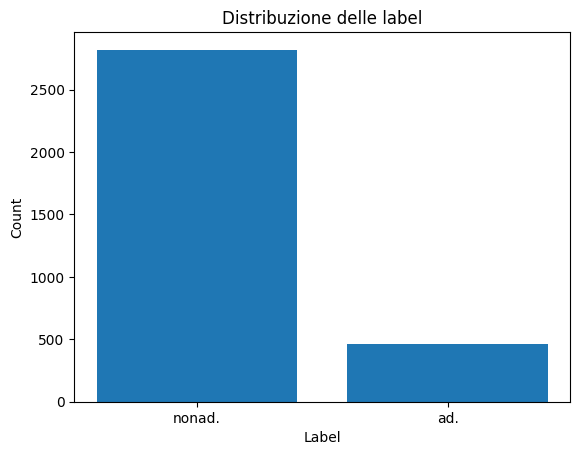

In [106]:
counts = df['label'].value_counts()
plt.bar(['nonad.', 'ad.'], counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribuzione delle label')
plt.show()

# Pre-processing dei dati <a id="pre-processing"></a>

## Gestione valori mancanti <a id="valori-mancanti"></a>

Verifica dei valori mancanti come indicato dalla documentazione

In [63]:
df.isna().sum()

height                903
width                 901
aratio                910
local                  15
url*images+buttons      0
                     ... 
caption*here            0
caption*click           0
caption*for             0
caption*you             0
label                   0
Length: 1559, dtype: int64

In [64]:
columns_with_missing_values = df.isna().sum() > 0
columns_with_missing_values[columns_with_missing_values]

height    True
width     True
aratio    True
local     True
dtype: bool

Come ci si aspettava rispetto alla documentazione, il dataset presenta diversi dati mancanti, di seguito il totale dei record affetti:

In [45]:
missing_data_rows = (df.isna().sum(axis=1) > 0).sum()
print(missing_data_rows)
print(str(round(missing_data_rows * 100 / df.shape[0], 2)) + "%")

920
28.06%


Di seguito i records con tutte e 4 le features con dati mancanti:

In [46]:
rec = df.loc[df[['height', 'width', 'aratio', 'local']].isna().all(axis=1)]
rec

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,label
1316,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
1327,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
1353,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,nonad.
1551,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
1881,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.


Osservato: 
* l'enorme disparità tra labels nonad e ad
* i records affetti da una mancanza totale di informazione per le feature continue sono solo lo 0.15% del totale
* i 5 records sono esclusivamente con label nonad.

Si sceglie di eliminare i records affetti da tale mancanza di informazione.

In [47]:
df = df.drop(rec.index)

Di seguito i records con le features height, width, aratio con dati mancanti:

In [48]:
(df[['height', 'width', 'aratio']].isna().all(axis=1)).sum()

889

Metodi per la loro gestione:

* **Eliminazione diretta delle colonne**: Come si nota, le features principalmente affette sono quelle con dati continui relative alle immagini. Una soluzione potrebbe essere l'eliminazione di `height`, `width` e `aratio`.

* **Eliminazione records**: Eliminare direttamente le righe con dati mancanti. Soluzione indicata per poche righe con dati mancanti, in questo caso si andrebbero ad eliminare 889 records, ovvero 27.11% del totale, scelta da ponderare con attenzione.

* **Sostituzione**: Sostituire i valori mancanti con un valore stimato:
  * **Sostituzione con la media**: i valori mancanti per le tre features sono circa 900, ovvero circa il 27.5% dei records circa per ogni feature;
  * **Sostituzione con la mediana**;
  * **Sostituzione con il valore più frequente (moda)**;
  * **Sostituzione KNN**: Le osservazioni sono considerate come punti nello spazio delle features e i valori mancanti sono stimati sulla base dei k vicini più prossimi.


In [50]:
df.describe()

,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,url*peace+images,url*blipverts,url*tkaine+kats,url*labyrinth,...,caption*of,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you
count,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,...,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000,3274.000000
mean,0.004276,0.011607,0.004582,0.003360,0.003971,0.011607,0.003360,0.004887,0.009163,0.004582,...,0.006109,0.004582,0.003665,0.002443,0.003054,0.006414,0.012828,0.013439,0.009469,0.001527
std,0.065262,0.107123,0.067542,0.057875,0.062898,0.107123,0.057875,0.069747,0.095299,0.067542,...,0.077931,0.067542,0.060439,0.049379,0.055190,0.079843,0.112551,0.115164,0.096859,0.039055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
